<a id=POST-PROCESAMIENTO-DESCRIPCIÓN></a>
# POST-PROCESAMIENTO DE ARCHIVOS TRANSITORIOS DE SIMULACIONES LES

El cometido de este código es proporcionar la funcionalidad para el post-procesamiento de los archivos transitorios (dependientes del parámetro temporal) de simulaciones LES sobre perfiles NACA0021 en distintas configuraciones.

<a id=IMPORTACIÓN-CARGA-PAQUETES></a>
# IMPORTACIÓN Y CARGA DE PAQUETES

Para importar los paquetes externos debidamente, han de tenerse instalados ciertos módulos en Python. Concretamente, y para la distribución "conda", los paquetes necesarios pueden instalarse mediante:

<ul>
    <li><b style="color:#FF0000";>numpy</b>: <code>conda install numpy</code> paquete para computación científica.</li>
    <li><b style="color:#FF0000";>matplotlib</b>: <code>conda install -c conda-forge matplotlib</code>; es necesario para el el ploteo de gráficas y diagramas.</li>
    <li><b style="color:#FF0000";>pickle</b>: <code>conda install -c conda-forge pickle5</code></li>
    <li><b style="color:#FF0000";>statistics</b>: <code>conda install -c conda-forge statistics</code>; es necesario para realizar ciertas operaciones de post-procesado.</li>
    <li><b style="color:#FF0000";>nptdms</b>: <code>conda install -c conda-forge nptdms</code>; es necesario para poder abrir archivos en formato TDMS, como se explica <a href=#PROCESAMIENTO-FICHEROS-TDMS>más abajo</a>.</li>
    <li><b style="color:#FF0000";>termcolor</b>: <code>conda install -c omnia termcolor</code>; necesario para poder escribir, en el terminal, texto a color. El color es empleado para dar cuenta de ciertas incidencias o fallos, así como indicar una adecuada carga de ficheros y su posterior procesamiento.</li>
    <li><b style="color:#FF0000";>dataclasses</b>: <code>conda install -c conda-forge dataclasses</code>; necesario para definir clases de datos y estructuras, de cara a desarrollar un código orientado a objetos (ver <a href=#PROCESAMIENTO-FICHEROS-TDMS>más abajo</a>).</li>
</ul>

Aunque parezca que no se hace un uso directo de todos esos módulos, se explica el porqué de su instalación a continuación. El bloque siguiente se encarga de importar los paquetes necesarios, y se clasifican en dos bloques:
<ul>
    <li>Paquetes externos:
        <ul>
            <li>numpy</li>
            <li>matplotlib</li>
            <li>statistics</li>
            <li>...</li>
        </ul></li>
    <li>Paquetes propios: son los desarrollados, expresamente, para la carga y el inicial post-procesamiento de datos provenientes de simulaciones. Estos paquetes <strong style="color:#FF0000";>no han de modificarse</strong>, y son los que emplean los módulos instalados aludidos anteriormente. El único paquete propio que se va a emplear es:
        <ul>
            <li>TDMSClasses: define todas las clases y métodos necesarios para crear objetos que repliquen los ficheros TDMS que provienen de los ensayos en túnel de viento.</li>
            <li>TDMSEnums: define todos las estructuras enumerativas que se emplean en TDMSClasses. Básicamente, variables que pueden tomar una serie de valores discretos.</li>
            <li>MathTools: conjunto de herramientas matemáticas necesarias para llevar a cabo ciertas operaciones de post-procesado.</li>
        </ul></li>
</ul>

In [4]:
# Paquetes externos.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import statistics as st
import pickle
import scipy as sc
import enum
import os
import importlib

# Paquetes y módulos propios.
import own_packages.TDMS_Packages.TDMSClasses as TDMSC
import own_packages.TDMS_Packages.TDMSEnums as TDMSE
import own_packages.Math_Tools.MathTools as mt

# Configurando el estilo de matplotlib por defecto.
plt.style.use('default')

Las siguientes clases (que heredan su estructura del objeto <code>Enum</code>, o sea, enumeraciones o estructuras de datos ordenadas) se declaran para facilitar el código posterior. Se emplean, básicamente, para:
    <ul>
    <li>clase <code>config</code>: indicar el tipo de configuración fluida al que un fichero de datos específico hace referencia.</li>
    <li>clase <code>curves</code>: indicar el tipo de curvas que contiene el fichero (sean curvas $c_{l}-c_{d}$ o curvas $c_{p}$.</li>
    <li>clase <code>mode</code>: indicar el tipo de modo que se emplea para la carga de ficheros (sea <code>"KIS"</code> para indicar que el fichero contiene medidas realizadas, únicamente, con la balanza piezoeléctrica "Kistler"; sea <code>"KIS_WR"</code> para indicar que las medidas se han realizado con la balanza y con el "wake-rake"; o sea <code>"SURFPRES"</code> para indicar que se han realizado medidas de presión superficial.</li>    
    </ul>

In [ ]:
# Clase "config" para indicar el tipo de configuración fluida al que un fichero de datos hace referencia.
class config(enum.Enum):
    CLEAN = "01_CLEAN_CONFIG"
    TURB = "02_TURB_CONFIG"
    ROUGH = "03_ROUGH_CONFIG"
    REAL = "04_REAL_CONFIG"

# Clase "curves" para indicar el tipo de curvas que contiene un fichero.
class curves(enum.Enum):
    CL_CD = "CL_CD_CURVES"
    CP = "CP_CURVES"
    
# Clase "mode" para indicar el modo que se emplea para la carag de ficheros.
class mode(enum.Enum):
    KIS = "KIS"
    KIS_WR = "KIS_WR"
    SURFPRES = "SURFPRES"

<a id=PROCESAMIENTO-FICHEROS-TDMS></a>
# PROCESAMIENTO DE FICHEROS TDMS

El almacenamiento de las mediciones del túnel de viento se ha realizado mediante su volcado en ficheros TDMS, que son unos ficheros "tipo" empleados por la marca National Instruments para facilitar tanto su almacenamiento como su posterior manipulación:
<ul>
    <li>Un fichero TDMS es un fichero binario con una estructura concreta. Cada fichero TDMS representa un ensayo realizado en el túnel de viento.</li>
    <li>Existe un plug-in para poder abrir estos ficheros en formato Excel, lo cual puede ser de utilidad para ver la estructura interna de los ficheros e, incluso, para poder realizar las acciones de post-procesado pertinentes; el plug-in puede descargarse <a href=https://www.ni.com/es-es/support/downloads/tools-network/download.tdm-excel-add-in-for-microsoft-excel.html#378046>aquí</a> y, una vez instalado, es cuestión de abrir los ficheros TDMS mediante doble click.</li>
    <li>Sin embargo, el código está escrito según el paradigma OOP (<a href=https://en.wikipedia.org/wiki/Object-oriented_programming>"object oriented programming"</a>); así, lo que se hace es crear un objeto que replique el fichero TDMS en una estructura (un diccionario, concretamente) de Python.</li>
    <li>La primera parte del código consiste en cargar los ficheros TDMS, crear la estructura u objeto pertinente (el diccionario) y guardar dicho objeto en formato <a href=https://en.wikipedia.org/wiki/Serialization>serializado</a> (o, para que se entienda, un formato binario que se pueda cargar mediante un módulo de Python). Así, lo que se guarda al final del código es el objeto de Python creado (el diccionario), para que no se tenga que volver a cargar el fichero TDMS toda las veces que se vuelva a correr el código. Esto redunda en una eficiencia de carga sustancial, ya que algunos ficheros TDMS pueden tener un peso considerable.</li>
    <li>El módulo de Python que permite generar y cargar ficheros serializados es el llamado <a href=https://docs.python.org/3/library/pickle.html>Pickle</a>. Al correr el código, y tras cargar el TDMS y generar el objeto-diccionario correspondiente, éste se guardará como objeto serializado (extensión ".p") en la misma carpeta de donde proviene el fichero TDMS.</li>
    <li>Una vez que se generan los objetos serializados, no hará falta correr esta parte del código, sino que podrá saltarse la sección e ir, directamente <a href=#CARGA-DATOS-EXPERIMENTALES>a la parte correspondiente a los datos experimentales</a>. De todas formas, y si se quieren volver a cargar los ficheros TDMS por alguna razón, puede ejecutarse este bloque de código sin ningún problema. Pero, en principio, la razón por la cual se incluye esta sección es para:
        <ul>
            <li>dar una visión global de cómo funciona el código, y de hacer ver que existe una trazabilidad entre los datos en crudo y los objetos-diccionario en formato Python que están listos para ser post-procesados.</li>
            <li>ejecutarlo una primera vez (al compartir la carpeta que contiene el código y los ficheros de datos, éstos últimos están en formato TDMS (no serializados) para evitar ocupar más espacio del debido).</li>
        </ul>
    </li>
</ul>

La única sección que se ha añadido, por el momento, es el correspondiente al de las curvas $x'-c_{p}$ de la configuración limpia (hay cuatro configuraciones de flujo: limpia-turbulenta-rugosa-real) y, dentro de la misma, la que corresponde al airfoil limpio (sin elementos de rugosidad discretos empleados como modo de control de flujo). A medida que se vayan añadiendo más ficheros, como los correspondientes a las mediciones de lift y drag, será conveniente mantener los bloques de código correspondientes en subsecciones apartadas, de cara a asegurar una legibilidad del código adecuada.


## CONFIGURACIÓN LIMPIA

### AIRFOIL LIMPIO (SIN RUGOSIDADES DISCRETAS)

#### CURVAS $x'-c_{p}$

En cuanto a la denominación de los ficheros y su significado:
<ul>
    <li>Téngase en cuenta que $x'$ hace referencia al parámetro adimensional en la dirección de la cuerda del airfoil. Cada fichero se corresponde con un número de Reynolds ($\text{Re}$) concreto, y los datos incluidos en el mismo son para distintas configuraciones de ángulo de ataque ($\alpha$).
Los nombres de los ficheros de datos están puestos para identificar lo que incluyen: la forma genérica que tienen tales ficheros es:
<br></br>
<br></br>
<center><b style="color:#FF0000";>tipo-de-medición__parámetro-espacial-principal__modelo-airfoil-empleado__valor-Reynolds__rango-parámetro-espacial-principal__repetición</b></center>
<br></br>
<center>(p. ej.: Surface_pressure_angleWise_bareAirfoil_elec_Re0,8e5_AoA-20_20_2)</center>
<br></br>
<br></br>
donde:
    <ul>
        <li>El <b style="color:#FF0000";>tipo-de-medición</b> es, en este caso, <b style="color:#FF0000";>Surface_pressure</b>; o sea, indica que se han realizado medidas de presión superficial.</li> 
        <li>El <b style="color:#FF0000";>parámetro-espacial-principal</b> es, en este caso, <b style="color:#FF0000";>angleWise</b>, indicado que las distintas medidas realizadas se corresponden con diferentes configuraciones de $\alpha$.</li>
        <li>El <b style="color:#FF0000";>modelo-airfoil-empleado</b> es, en este caso, <b style="color:#FF0000";>bareAirfoil_elec</b>; la alocución <b style="color:#FF0000";>bareAirfoil</b> indica que las medidas se han realizado sobre el airfoil sin rugosidades discretas. Por su parte, el término <b>elec</b> sirve para identificar el airfoil que se ha empleado como modelo, y no reviste mayor importancia (es un parámetro que tiene relevancia para el registro interno en el túnel de viento.</li>
        <li>El <b style="color:#FF0000";>valor-Reynolds</b> toma la forma <b style="color:#FF0000";>Re#</b>, donde <b style="color:#FF0000";>#</b> indica el número de Reynolds al que se ha realizado el ensayo. Podrá tomar valores entre 0.8e5 y 1.6e5.</li>
        <li>El <b style="color:#FF0000";>rango-parámetro-espacial-principal</b> indica el rango en el que se ha variado, en este caso, el ángulo de ataque. Como todos los ensayos están realizados variando el ángulo de ataque entre $\alpha\in\left[-20, 20\right]^{\circ}$, este parámetro adquirirá la forma <b style="color:#FF0000";>AoA-20_20.</b></li>
        <li>El parámetro <b style="color:#FF0000";>repetición</b> existe para identificar los distintos ensayos que se han realizado sobre la misma configuración. Para asegurar una correcta convergencia estadística al analizar los datos, cada configuración se ha ensayado un mínimo de 3 veces. El hecho de que un fichero no tenga el parámetro de repetición indica que es el primero de los ensayos realizados sobre dicha configuración. Las dos repeticiones restantes se identifican como 2 y 3.</li>
    </ul></li>
    <li>Los bloques de código siguiente no solo realizan la carga de los ficheros TDMS, sino que también llevan a cabo parte del post-procesamiento. Concretamente:
    <ul>
        <li>Se adimensionalizan todas las variables con ciertas magnitudes de referencia. Las magnitudes de referencia que se pasan explícitamente como argumentos son la longitud de la cuerda, la longitud del "span" y el espesor máximo del airfoil correspondientes al NACA0021. De emplearse algún otro airfoil con características geométricas distintas, estas magnitudes deberían ser las de ese otro airfoil. Las magnitues de referencia de velocidad, presión, presión dinámica...se establecen automáticamente a partir de la lectura del fichero de datos. De todas formas, dichas magnitudes también pueden especificarse en caso necesario. Con todo, el diccionario-objeto de Python que se genera al final estará adimensionalizado. Dicha adimensionalización puede revertirse <i>a posteriori</i>.</li>
        <li>Se completa el análisis de incertidumbre correspondiente de acuerdo a los principios establecidos en el <a href=https://www.sciencedirect.com/science/article/pii/S0263224120304796> artículo correspondiente</a>.</li>
    </ul></li>
    <li>Tanto la lectura de los ficheros TDMS, las operaciones de post-procesado necesarias, y el volcado del objeto-diccionario serializado resultante en un fichero Pickle dependen de unas funciones ("métodos", en rigor) que se encuentran en los paquetes propios que se han cargado en la <a href=#IMPORTACIÓN-CARGA-PAQUETES>sección correspondiente</a>. Algunas puntualizaciones al respecto:
    <ul>
        <li>Los ficheros TDMS se cargan mediante el empleo de dos funciones: <code python>TdmsFileData</code> y <code python>open_list_of_files()</code>. La función <code python>TdmsFileData</code> no es una función como tal, sino la instanciación de un objeto (por eso no aparece un paréntesis <code python>()</code> al final; las funciones se distinguirán por tener que ser llamadas o invocadas de alguna manera, que es lo que los paréntesis al final del nombre de la función indican, como en el caso de <code python>open_list_of_files()</code>). Siempre que se le llama, crea un objeto correspondiente a un fichero TDMS. La descripción de los argumentos que se le pasan en el momento de la instanciación pueden verse en la documentación pertinente, haciendo <code python>TDMSC.TdmsFileData.__init__?</code>; aunque, dicho sea de paso, el primer y segundo argumentos representan, respectivamente, la ruta del fichero TDMS y el nombre que se le quiere dar al objeto instanciado. La estructura del objeto <code python>TdmsFileData</code> genérico, definido en el fichero <i>TDMSClasses.py</i>, no ha de modificarse en principio.</li>
        <li>Una vez se constituye la lista de ficheros a leer (siempre ha de ser una lista, aunque el fichero a leer sea único), cada uno de los ficheros instanciados en formato <code python>TdmsFileData</code> se lee mediante la llamada a la función <code python>open_list_of_files()</code>. Al igual que la estructura genérica <code python>TdmsFileData</code>, esta función reside en el fichero <i>TDMSClasses.py</i>, y no ha de modificarse en principio.</li>
    </ul></li>
    </ul>

In [3]:
# Se declara la variable 'path' para indicar la ruta (el directorio) donde se encuentran los ficheros.
path = "Exp_data/Clean_config/Bare_airfoil/cp/"
# Se declara la varaible 'list_of_files' como una lista vacía. Esta variable se compondrá de todos
# los objetos TDMS que se quieren cargar.
list_of_files = list()

#############################################################################################################
################FICHEROS DE DATOS CORRESPONDIENTES A MEDICIONES DE PRESIÓN SUPERFICIAL#################
#############################################################################################################

# Ficheros de ensayos a Re=0.8e5
list_of_files.append((TDMSC.TdmsFileData(path + "Surface_pressure_angleWise_bareAirfoil_elec_Re0,8e5_AoA-20_20/rawData_0.tdms",
                            "Bare_Re_80_e_3_m20_20_SURFPRES_HYST",
                            "",
                            TDMSE.tdmsFilereadMode.surface_pressure,
                            TDMSC.RefMagnitudes(length = 0.15, span = 0.9, thick = 0.15*0.21)
                            ), mode.SURFPRES))
list_of_files.append((TDMSC.TdmsFileData(path + "Surface_pressure_angleWise_bareAirfoil_elec_Re0,8e5_AoA-20_20_2/rawData_1.tdms",
                            "Bare_Re_80_e_3_m20_20_SURFPRES_HYST_2",
                            "",
                            TDMSE.tdmsFilereadMode.surface_pressure,
                            TDMSC.RefMagnitudes(length = 0.15, span = 0.9, thick = 0.15*0.21)
                            ), mode.SURFPRES))
list_of_files.append((TDMSC.TdmsFileData(path + "Surface_pressure_angleWise_bareAirfoil_elec_Re0,8e5_AoA-20_20_3/rawData_2.tdms",
                            "Bare_Re_80_e_3_m20_20_SURFPRES_HYST_3",
                            "",
                            TDMSE.tdmsFilereadMode.surface_pressure,
                            TDMSC.RefMagnitudes(length = 0.15, span = 0.9, thick = 0.15*0.21)
                            ), mode.SURFPRES))

# Ficheros de ensayos a Re=1e5
list_of_files.append((TDMSC.TdmsFileData(path + "Surface_pressure_angleWise_bareAirfoil_elec_Re1e5_AoA-20_20/rawData_0.tdms",
                            "Bare_Re_100_e_3_m20_20_SURFPRES_HYST",
                            "",
                            TDMSE.tdmsFilereadMode.surface_pressure,
                            TDMSC.RefMagnitudes(length = 0.15, span = 0.9, thick = 0.15*0.21)
                            ), mode.SURFPRES))
list_of_files.append((TDMSC.TdmsFileData(path + "Surface_pressure_angleWise_bareAirfoil_elec_Re1e5_AoA-20_20_2/rawData_1.tdms",
                            "BBare_Re_100_e_3_m20_20_SURFPRES_HYST_2",
                            "",
                            TDMSE.tdmsFilereadMode.surface_pressure,
                            TDMSC.RefMagnitudes(length = 0.15, span = 0.9, thick = 0.15*0.21)
                            ), mode.SURFPRES))
list_of_files.append((TDMSC.TdmsFileData(path + "Surface_pressure_angleWise_bareAirfoil_elec_Re1e5_AoA-20_20_3/rawData_2.tdms",
                            "Bare_Re_100_e_3_m20_20_SURFPRES_HYST_3",
                            "",
                            TDMSE.tdmsFilereadMode.surface_pressure,
                            TDMSC.RefMagnitudes(length = 0.15, span = 0.9, thick = 0.15*0.21)
                            ), mode.SURFPRES))

# Ficheros de ensayos a Re=1.2e5
list_of_files.append((TDMSC.TdmsFileData(path + "Surface_pressure_angleWise_bareAirfoil_elec_Re1,2e5_AoA-20_20/rawData_0.tdms",
                            "Bare_Re_120_e_3_m20_20_SURFPRES_HYST",
                            "",
                            TDMSE.tdmsFilereadMode.surface_pressure,
                            TDMSC.RefMagnitudes(length = 0.15, span = 0.9, thick = 0.15*0.21)
                            ), mode.SURFPRES))
list_of_files.append((TDMSC.TdmsFileData(path + "Surface_pressure_angleWise_bareAirfoil_elec_Re1,2e5_AoA-20_20_2/rawData_1.tdms",
                            "Bare_Re_120_e_3_m20_20_SURFPRES_HYST_2",
                            "",
                            TDMSE.tdmsFilereadMode.surface_pressure,
                            TDMSC.RefMagnitudes(length = 0.15, span = 0.9, thick = 0.15*0.21)
                            ), mode.SURFPRES))
list_of_files.append((TDMSC.TdmsFileData(path + "Surface_pressure_angleWise_bareAirfoil_elec_Re1,2e5_AoA-20_20_3/rawData_2.tdms",
                            "Bare_Re_120_e_3_m20_20_SURFPRES_HYST_3",
                            "",
                            TDMSE.tdmsFilereadMode.surface_pressure,
                            TDMSC.RefMagnitudes(length = 0.15, span = 0.9, thick = 0.15*0.21)
                            ), mode.SURFPRES))

# Ficheros de ensayos a Re=1.4e5
list_of_files.append((TDMSC.TdmsFileData(path + "Surface_pressure_angleWise_bareAirfoil_elec_Re1,4e5_AoA-20_20/rawData_0.tdms",
                            "Bare_Re_140_e_3_m20_20_SURFPRES_HYST",
                            "",
                            TDMSE.tdmsFilereadMode.surface_pressure,
                            TDMSC.RefMagnitudes(length = 0.15, span = 0.9, thick = 0.15*0.21)
                            ), mode.SURFPRES))
list_of_files.append((TDMSC.TdmsFileData(path + "Surface_pressure_angleWise_bareAirfoil_elec_Re1,4e5_AoA-20_20_2/rawData_1.tdms",
                            "Bare_Re_140_e_3_m20_20_SURFPRES_HYST_2",
                            "",
                            TDMSE.tdmsFilereadMode.surface_pressure,
                            TDMSC.RefMagnitudes(length = 0.15, span = 0.9, thick = 0.15*0.21)
                            ), mode.SURFPRES))
list_of_files.append((TDMSC.TdmsFileData(path + "Surface_pressure_angleWise_bareAirfoil_elec_Re1,4e5_AoA-20_20_3/rawData_2.tdms",
                            "Bare_Re_140_e_3_m20_20_SURFPRES_HYST_3",
                            "",
                            TDMSE.tdmsFilereadMode.surface_pressure,
                            TDMSC.RefMagnitudes(length = 0.15, span = 0.9, thick = 0.15*0.21)
                            ), mode.SURFPRES))

# Ficheros de ensayos a Re=1.6e5
list_of_files.append((TDMSC.TdmsFileData(path + "Surface_pressure_angleWise_bareAirfoil_elec_Re1,6e5_AoA-20_20/rawData_0.tdms",
                            "Bare_Re_160_e_3_m20_20_SURFPRES_HYST",
                            "",
                            TDMSE.tdmsFilereadMode.surface_pressure,
                            TDMSC.RefMagnitudes(length = 0.15, span = 0.9, thick = 0.15*0.21)
                            ), mode.SURFPRES))
list_of_files.append((TDMSC.TdmsFileData(path + "Surface_pressure_angleWise_bareAirfoil_elec_Re1,6e5_AoA-20_20_2/rawData_1.tdms",
                            "Bare_Re_160_e_3_m20_20_SURFPRES_HYST_2",
                            "",
                            TDMSE.tdmsFilereadMode.surface_pressure,
                            TDMSC.RefMagnitudes(length = 0.15, span = 0.9, thick = 0.15*0.21)
                            ), mode.SURFPRES))
list_of_files.append((TDMSC.TdmsFileData(path + "Surface_pressure_angleWise_bareAirfoil_elec_Re1,6e5_AoA-20_20_3/rawData_2.tdms",
                            "Bare_Re_160_e_3_m20_20_SURFPRES_HYST_3",
                            "",
                            TDMSE.tdmsFilereadMode.surface_pressure,
                            TDMSC.RefMagnitudes(length = 0.15, span = 0.9, thick = 0.15*0.21)
                            ), mode.SURFPRES))

# Instrucción de apertura mediante llamada al método "open_list_of_files()".
TDMSC.open_list_of_files([_[0] for _ in list_of_files], reload=True)

----------Attempting Bare_Re_80_e_3_m20_20_SURFPRES_HYST----------
Sequential runs: check correct --> Ordering: (angle) --> Numbering: (81)
Saving serialized object in Pickle file: Bare_Re_80_e_3_m20_20_SURFPRES_HYST.p
TDMS file 1 of 15 opened in surface_pressure mode; Bare_Re_80_e_3_m20_20_SURFPRES_HYST global variable has been created.
----------Attempting Bare_Re_80_e_3_m20_20_SURFPRES_HYST_2----------
Sequential runs: check correct --> Ordering: (angle) --> Numbering: (81)
Saving serialized object in Pickle file: Bare_Re_80_e_3_m20_20_SURFPRES_HYST_2.p
TDMS file 2 of 15 opened in surface_pressure mode; Bare_Re_80_e_3_m20_20_SURFPRES_HYST_2 global variable has been created.
----------Attempting Bare_Re_80_e_3_m20_20_SURFPRES_HYST_3----------
Sequential runs: check correct --> Ordering: (angle) --> Numbering: (81)
Saving serialized object in Pickle file: Bare_Re_80_e_3_m20_20_SURFPRES_HYST_3.p
TDMS file 3 of 15 opened in surface_pressure mode; Bare_Re_80_e_3_m20_20_SURFPRES_HYST_3 gl

## ACCESO A DATOS $c_{p}$ EXPERIMENTALES

In [ ]:
Bare_Re_100_e_3_m20_20_SURFPRES_HYST.groups_added.surface_pressure_group.angle.angle_surface_pressure_values

<a id=PROCEDIMIENTO-SIMULACIÓN-ESTRUCTURA-FICHEROS></a>
# PROCEDIMIENTO DE SIMULACIÓN Y ESTRUCTURA DE FICHEROS

Las funciones de lectura de archivos tienen por objetivo leer distintos tipos de archivos que se han extraído de las simulaciones numéricas. Los casos numéricos que se han simulado se corresponden con un airfoil de geometría específica, un NACA0021, sometido a un flujo transicional con un número de Reynolds (basado en la cuerda) de $1.2{\cdot}10^{5}$, y configurado a distintos ángulos de ataque ($\alpha$).

Las simulaciones se han corrido con el modelo LES y empleando el software comercial ANSYS Fluent. El dominio computacional, así como los parámetros numéricos, se han configurado de la siguiente manera:
<ul>
    <li><b style="color:#FF0000";>Dominio computacional</b>:
        <ul>
            <li><b style="color:#008000";>Geometría</b>: paralelepípedo 3D. El plano $x-y$ se corresponde con las dimensiones del túnel de viento en el que se han realizado las contrapartidas experimentales. La cuerda del perfil es de $c=150$ mm; la distancia desde la frontera de entrada hasta el borde de ataque de perfil es de $3c$, y del borde de salida del perfil hasta la frontera de salida, de $5c$. La dimensión transversal es de $5c$. La anchura (en el eje $z$) que se le ha dado al dominio computacional es de $0.1c$. El borde de salida del perfil se ha truncado a la altura de la dimensión de la cuerda, o sea, en el punto $x=150$ (tomando $x=0$ en el borde de ataque). El plano transversal $x-y$ correspondiente a una configuración del perfil de 0º puede verse en la siguiente figura: <img src="Figuras/virtual_domain_and_mesh_figure.png"></li>            
            <li><b style="color:#008000";>Mallado</b>: se ha configurado una topología que divide entre un campo o dominio fluido lejano y uno cercano al perfil. Se ha realizado un stretching de la malla en el dominio cercano, para así capturar la física subyacente. Las mallas tienen un total de $\approx7.5\cdot10^6$ celdas, con cada plano $x-y$ disponiendo de $\approx10^5$ elementos.</li>
            <li><b style="color:#008000";>Monitorización de variables</b>: para la monitorización de algunas variables fluidas de interés, se disponen de las siguientes zonas en el campo fluido:
                <ul>
                    <li>La cuerda media según el eje $z$. Durante la simulación, se computan los valores de:
                        <ul>
                            <li>coeficiente de presión, $c_{p}$.</li>
                            <li>coeficiente de fricción $c_{f}$.</li>
                            <li>fricción en la pared según el eje $x$ ($\tau_{x}$).</li>
                        </ul>
                    </li>
                    <li>En la misma cuerda media se han establecido una serie de líneas de monitorización tanto sobre el intradós (<i>pressure-side</i>) como sobre el extradós (<i>suction-side</i>) del perfil. Estas líneas se extienden entre el perfil y el límite topológico del campo cercano, y son perpendiculares al perfil en cada punto de la superficie del mismo. Durante la simulación, se monitorizan:
                        <ul>
                            <li>el componente de velocidad $v_{x}$ sobre cada línea.</li>
                            <li>el componente de velocidad $v_{y}$ sobre cada línea.</li>
                        </ul>
                        Estos componentes de velocidad pueden emplearse, cerca del perfil, para calcular los perfiles de velocidad $v_{x}\left(y\right)$ y $v_{y}\left(y\right)$ de la capa límite. Hay 103 líneas tanto en el intradós como en el extradós, además de una línea que parte del borde de ataque, y se denominan y numeran tal y como aparece en la siguiente figura: <img src="Figuras/monitoring_lines.png">
                    </li>                    
                    <li>En el plano $x-y$ medio a lo largo del eje $z$, se establecen unas líneas verticales (se extienden cubriendo la dimensión del eje $y$ en su totalidad) a diferentes distancias aguas abajo del perfil. Hay un total de 14 líneas distintas, que se emplean para monitorizar:
                        <ul>
                            <li>la magnitud de la velocidad, $|v|$, sobre cada línea.</li>
                            <li>el componente de velocidad $v_{x}$ sobre cada línea.</li>
                        </ul>
                        Estas magnitudes pueden emplearse para calcular la curva de déficit de cantidad de movimiento aguas abajo del perfil, el cual debería correlacionar con las mediciones experimentales del coeficiente de resistencia aerodinámica.
                    </li>
                </ul>
            </li>
        </ul>
    <li><b style="color:#FF0000";>Simulaciones</b>:
        <ul>
            <li><b style="color:#008000";>Condiciones de contorno</b>: las condiciones de contorno impuestas son:
                <ul>
                    <li><b>Inlet</b>: velocidad normal al contorno, de un valor de 11.683 m/s (que corresponde con un Reynolds basado en cuerda de $1.2\cdot10^5$). No se introduce turbulencia alguna.</li>
                    <li><b>Outlet</b>: condición de "<i>pressure-outlet</i>".</li>
                    <li><b>Límites superior e inferior en el eje $y$</b>: condición de pared.</li>
                    <li><b>Límites superior e inferior en el eje $z$</b>: condición de simetría.</li>
                    <li><b>Superficie del perfil</b>: condición de pared.</li>
                </ul>                
            </li>
            <li><b style="color:#008000";>Ejecución</b>: las simulaciones se ejecutan en:
                <ul>
                    <li>modo transitorio, con un incremento temporal de $\Delta{t}=10^{-5}$ segundos.</li>
                    <li>con criterios de convergencia en los residuales de continuidad y las tres componentes de velocidad de $10^{-4}$.</li>
                    <li>con el primer segundo físico empleado en obtener una convergencia en la solución.</li>
                    <li>con los restantes 5 segundos físicos empleados en registrar las varaibles fluidas de interés. Se emplean 5 segundos para que la serie de datos se corresponda con las medidas experimentales, que son también de 5 segundos.</li>
                    <li>con las variables de interés monitorizadas cada $10^{-3}$ segundos o, equivalentemente, cada $10^{2}$ pasos temporales.</li>
                </ul>
            </li>
        </ul>
    </li>
    <li><b style="color:#FF0000";>Ficheros</b>:
        <ul>
            <li><b style="color:#008000";>Estructura de ficheros</b>: los paquetes de ficheros obtenidos se corresponden con cada ángulo de ataque simulado. Cada caso de $\alpha$ tiene un directorio que se identifica con el nombre "AdA$\alpha$"; por ejemplo, los datos correspondientes a una configuración a 4º se encuentran dentro del directorio "AdA4". Dentro de cada directorio se tienen los siguientes ficheros y subdirectorios:
            <br/>
            <br/>
            <ul>
                <li><b>line_coordinates.txt</b>: fichero de texto que contiene las coordenadas de inicio y final de cada línea de monitorización que aparece en el dominio computacional. Aparecen las coordenadas de las líneas de extradós e intradós, así como de las líneas que se encuentran aguas abajo del perfil. La estructura del fichero es:
                    <br/>                    <b>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;; TIPO-LÍNEA</b>
                    <center><b>NOMBRE-LINEA</b> x0 y0 z0 x1 y1 z1</center>
                    <center><b>NOMBRE-LINEA</b> x0 y0 z0 x1 y1 z1</center>
                    <center><b>NOMBRE-LINEA</b> x0 y0 z0 x1 y1 z1</center>
                    <center>...</center>
                    <br/>                    <b>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;; TIPO-LÍNEA</b>
                    <center><b>NOMBRE-LINEA</b> x0 y0 z0 x1 y1 z1</center>
                    <center><b>NOMBRE-LINEA</b> x0 y0 z0 x1 y1 z1</center>
                    <center><b>NOMBRE-LINEA</b> x0 y0 z0 x1 y1 z1</center>
                    <center>...</center>                    
Donde "<b>; TIPO-LÍNEA</b>" indica el tipo de o familia de líneas especificadas a continuación (leading-edge, suction-side, pressure-side, momentum-deficit) y cada línea subsiguiente indica el nombre o la denominación que se le da y sus coordenadas (x, y, z) de inicio (0) y final (1).
                </li>
                <br/>
                <br/>
                <li><b>lift-drag</b>: subdirectorio que contiene dos ficheros:
                <ul>
                    <li><b>drag-coef.out</b>: contiene los datos temporales correspondientes al coeficiente de resistencia aerodinámica.</li>
                    <li><b>lift-coef.out</b>: contiene los datos temporales correspondientes al coeficiente de sustentación aerodinámica.</li>
                </ul>La estructura de los ficheros es:
                    <br/>
                    <b>&nbsp;&nbsp;&nbsp;&nbsp;METADATOS</b>
                    <br/>
                    <b>&nbsp;&nbsp;&nbsp;&nbsp;# Iteración</b>&nbsp;&nbsp;&nbsp;&nbsp;<b>valor coeficiente</b>&nbsp;&nbsp;&nbsp;&nbsp;<b>parámetro temporal</b>
                </li>
            </ul></li>
            <br/>
            <br/>
            <li><b>momentum_deficit_lines_velmag</b>, <b>momentum_deficit_lines_x_vels</b>: subdirectorios que contienen los ficheros correspondientes a las monitorizaciones de velocidades en las líneas aguas abajo del perfil. Dentro de cada subdirectorio hay una serie de ficheros que se corresponden con la denominación:
            <br/>
            <br/>
                <center><b>subdirectorio-matriz_valor-parametro-temporal.txt</b></center>
            <br/>
donde "<b>subdirectorio-matriz</b>" hace referencia bien a "momentum_deficit_lines_velmag", bien a "momentum_deficit_lines_x_vels", y "<b>valor-parametro-temporal</b>" es el valor del parámetro temporal para el que se ha registrado dicho fichero, y tiene el formato:
            <br/>
            <br/>
                <center><b>valor-parametro-temporal=00_._ _ _0000</b></center>
            <br/>
Así, por ejemplo:
            <br/>
            <br/>
                <center><b>momentum_deficit_lines_velmag_002.3270000</b></center>
            <br/>
contiene los datos obtenidos en cada línea de monitorización aguas abajo del perfil en el segundo físico 2.327 de la simulación. Dentro de cada uno de estos ficheros, la estructura es la siguiente:
                    <br/>
                    <b>&nbsp;&nbsp;&nbsp;&nbsp;METADATOS</b>
                    <br/>
                    <b>&nbsp;&nbsp;&nbsp;&nbsp;((xy/key/label NOMBRE-LINEA)</b>
                    <br/>
                    <b>&nbsp;&nbsp;&nbsp;&nbsp;valor velocidad&nbsp;&nbsp;&nbsp;&nbsp;coordenada y</b>
                    <br/>
                    <b>&nbsp;&nbsp;&nbsp;&nbsp;valor velocidad&nbsp;&nbsp;&nbsp;&nbsp;coordenada y</b>
                    <br/>
                    <b>&nbsp;&nbsp;&nbsp;&nbsp;valor velocidad&nbsp;&nbsp;&nbsp;&nbsp;coordenada y</b>
                    <br/>
                    <b>&nbsp;&nbsp;&nbsp;&nbsp;...</b>
            </li>
            <br/>
            <br/>
            <li><b>pressureside_bl_x_vels</b>, <b>pressureside_bl_y_vels</b>, <b>suctionside_bl_x_vels</b>, <b>suctionside_bl_y_vels</b>: subdirectorios que contienen los ficheros correspondientes a las monitorizaciones de componentes de velocidad sobre las líneas que parten de las superficies del perfil. La denominación de los ficheros en cada subdirectorio, así como la estructura interna de los ficheros, coincide con las de los subdirectorios <b>momentum_deficit_lines_velmag</b>, <b>momentum_deficit_lines_x_vels</b> mencionados anteriormente.</li>
            <br/>
            <br/>
            <li><b>pressureside_cfs</b>, <b>pressureside_cps</b>, <b>pressureside_tauxs</b>, <b>suctionside_cfs</b>, <b>suctionside_cps</b>, <b>suctionside_tauxs</b>: subdirectorios que contienen los ficheros correspondientes a las monitorizaciones de coeficientes de fricción, coeficientes de presión y esfuerzo de pared en dirección del eje $x$ obtenidos sobre la superficie de la cuerda media. La denominación de los ficheros en cada subdirectorio, así como la estructura interna de los ficheros, coincide con las de los subdirectorios <b>momentum_deficit_lines_velmag</b>, <b>momentum_deficit_lines_x_vels</b> mencionados anteriormente. La única diferencia es que, en estos ficheros, hay una única línea de monitorización, que se corresponde bien con la superficie de extradós, bien con la de intradós.</li>
        </ul>
    </li>
</ul>

<a id=FUNCIONES-LECTURA-ARCHIVOS></a>
# FUNCIONES DE LECTURA DE ARCHIVOS

Las funciones que se definen a continuación son para la lectura de cada tipo de archivos mencionados en la <a href=#PROCEDIMIENTO-SIMULACIÓN-ESTRUCTURA-FICHEROS>sección correspondiente</a>.

<a id=FUNCIÓN-LIFT-DRAG-READ()></a>
### FUNCIÓN lift_drag_read()

Función para leer ficheros de coeficientes de lift y drag.

In [5]:
def lift_drag_read(files):
    '''Reads files containing lift-drag data obtained from numerical simulations.
    
   - **parameters**, **returns**, **rtypes**
    
    :param files: lift-drag data files to be read.
    :returns:
        -array containing lift data.
        -array containing drag data.
        -array containing temporal data.
    :rtype: dict{array, array, array}
    '''
    
    # Retrieving lift and drag files from the 'files' input parameter.
    lift_file = [_ for _ in files if "lift-coef.out" in _][0]
    drag_file = [_ for _ in files if "drag-coef.out" in _][0]
    
    # Reading the lift, temp and drag data from the files and storing them in local variables.
    lift, temp = np.loadtxt(open(lift_file).readlines()[:-1], skiprows=3, delimiter=' ', usecols=(1, 2), unpack=True)    
    drag = np.loadtxt(open(drag_file).readlines()[:-1], skiprows=3, delimiter=' ', usecols=(1), unpack=True)
    
    # Return statement by dumping the previous local variables into a data-dictionary.
    return dict([_ for _ in locals().items() if any([__ == _[0] for __ in ["lift", "drag", "temp"]])])
    

<a id=FUNCIÓN-MOMENTUM-DEFICIT-READ()></a>
### FUNCIÓN momentum_deficit_read()

Función para leer los ficheros de componentes de velocidad de las líneas de déficit de momento, aguas abajo del perfil.

In [6]:
def momentum_deficit_read(files):
    '''Reads a number of files containing momentum-deficit-related data obtained from
    numerical simulations.
    
   - **parameters**, **returns**, **rtypes**
    
    :param files: list or array of files to be read.
    :returns:
        -set of arrays comprising the y coordinates of the stage at which the velocities are
    collected for computing the momentum-deficit parameter.
        -set of arrays comprising the measured velocities.
        -array comprising the average of the coordinates at which the velocities are collected.
        -array comprising the average of the measured velocities.
    :rtype: dict{arrays, arrays, array, array}
    '''
    
    # Computing the number of momentum-deficit lines to be read, from the first file.
    firstfile = files[0]
    data = open(firstfile).readlines()
    count = 0
    for _ in data:
        if "momentum_deficit" in _:
            count += 1

    # Instantiating local variables according to the number of lines to be read.
    for _ in range(1, count + 1):
        locals()["y_coords_" + str(_)] = list()
        locals()["y_coords_ave_" + str(_)] = None
        locals()["momentum_deficits_" + str(_)] = list()
        locals()["momentum_deficits_ave_" + str(_)] = None
        
    # Loop for getting the skipping rows and maximum rows to be read from the files.
    for e, file in enumerate(files):
        data = open(file).readlines()
        i = 0
        skip_rows = list()
        max_rows = list()
        for momentum_line in range(1, count + 1):
            while True:
                if "momentum_deficit_line_" + str(momentum_line) in data[i]:
                    skip_rows.append(i + 1)
                    if len(skip_rows) > 1:
                        max_rows.append(skip_rows[-1] - skip_rows[-2] - 3)
                    break
                else:
                    i += 1
        max_rows.append(skip_rows[-1] - skip_rows[-2] - 3)

        # Loop for reading the files and saving the read data in the previously defined variables.
        for f, _ in enumerate(skip_rows):
            g = f + 1
            y_coord = list()
            momentum_deficit = list()
            for __ in sorted(np.loadtxt(data, skiprows=skip_rows[f], max_rows=max_rows[f], usecols=(0, 1), delimiter="\t"), key=lambda x: x[1]):
                y_coord.append(__[1])
                momentum_deficit.append(__[0])
            diffs = np.abs(np.diff(momentum_deficit))    
            ind1, ind2 = 1 + [_ < 1e-2 for _ in diffs].index(True), len(diffs) - [_ < 1e-2 for _ in diffs[::-1]].index(True)
            locals()["y_coords_" + str(g)].append(y_coord[ind1:ind2])
            locals()["momentum_deficits_" + str(g)].append(momentum_deficit[ind1:ind2])

        # loop for computing the average values and storing them in the previously defined variables.
        for _ in range(1, count + 1):
            locals()["y_coords_ave_" + str(_)] = np.array([_ for _ in map(sum, zip(*locals()["y_coords_" + str(_)]))])/len(files)
            locals()["momentum_deficits_ave_" + str(_)] = np.array([_ for _ in map(sum, zip(*locals()["momentum_deficits_" + str(_)]))])/len(files)        
                    
    # Return statement.
    return dict([_ for _ in locals().items() if "y_coords" in _[0] or "momentum_deficits" in _[0]])

<a id=FUNCIÓN-CP-CF-TAUX-READ()></a>
### FUNCIÓN cp_cf_taux_read()

Función para leer los ficheros de coeficientes de fricción, coeficientes de presión o esfuerzo en pared en la dirección del eje $x$ sobre la cuerda media del perfil.

In [7]:
def cp_cf_taux_read(files, t0 = 1, dt = 1e-3):
    '''Reads a number of files containing cp, cf or taux data obtained from
    numerical simulations.
    
   - **parameters**, **returns**, **rtypes**
    
    :param files: list or array of files to be read.
    :param t0: initial temporal value.
    :param dt: temporal increment between measurements stored in adjacent files.
    :returns:
        -array comprising the x coordinates of the airfoil's chord.
        -array comprising the temporal parameter for the measured values.
        -set of arrays comprising the measured coefficient values.
        -set of arrays (obtained by reordering the previous ones) that show the temporal variation
        of the coefficients at each of the measured points.
    :rtype: dict{array, array, arrays, arrays}
    '''
    
    # instantiating local variables for chordwise and temporal coordinates, and lists for storing
    # chordwise and temporal variations of coefficients.
    x_coords = list()
    temp_coords = list()
    cs = list()
    cs_temp = list()

    # loop for reading the files and storing the data in the previously instantiated variables.
    for e, file in enumerate(files):
        temp_coords.append(t0 + (e + 1)*dt)
        c = list()
        for __ in sorted(np.loadtxt(open(file).readlines()[:-1], skiprows=4, usecols=(0, 1), delimiter="\t"), key=lambda x: x[1]):
            if e == 0:
                x_coords.append(__[1])
            c.append(__[0])
        cs.append(c)
    temp_coords = np.array(temp_coords)
    for _ in zip(*cs):
        cs_temp.append(np.array(_))
    cs_ave = np.array([_ for _ in map(sum, zip(*cs))])/len(files)
    
    # return statement.
    return dict([_ for _ in locals().items() if "coords" in _[0] or "cs" in _[0]])

<a id=FUNCIÓN-TRANS-FILE-READ()></a>
### FUNCIÓN trans_file_read()

Función genérica para la lectura de archivos. Dependiendo del parametro <code>mode</code> que se le pase, leerá un tipo de archivo u otro, llamando a las funciones que se han definido anteriormente.

In [8]:
def trans_file_read(filepath, mode):
    '''File for reading a set of transient files obtained from numerical simulations.
   
   - **parameters**, **returns**, **rtypes**
    
    :param filepath: root path where the files are located.
    :param mode: refers to the type of files that are to be read:
        -momentum_deficit_lines_velmag: reads the velocity magnitude at the momentum-deficit lines.
        -momentum_deficit_liens_x_vels: reads the x-velocity component at the momentum-deficit lines.
        -bl-x-vels: reads the x-velocity component at the boundary-layer lines.
        -bl-y-vels: reads the y-velocity component at the boundary-layer lines.
        -cfs: reads the chordwise distributions of the skin-friction coefficients.
        -cps: reads the chordwise distributions of the pressure coefficients.
        -tauxs: reads the chordwise distributions of the wall shear's x component.    
    :returns:
        -dictionary comprising the read values.
    :rtype: dict       
    '''
    
    # assertion statement for ensuring that the 'mode' input parameter has an accepted value.
    assert mode in ["lift-drag",
                    "momentum_deficit_lines_velmag",
                    "momentum_deficit_lines_x_vels",
                    "bl_x_vels",
                    "bl_y_vels",
                    "cfs",
                    "cps",
                    "tauxs"], "Please provide a valid 'mode' value."
    
    # conditional for calling the proper method for reading the set of files.
    # if the data to be read is related to the momentum-deficit lines:
    if "momentum_deficit" in mode:
        # constructing the path and the set of files to be read.
        files = ["/".join([filepath, mode, _]) for _ in os.listdir("/".join([filepath, mode]))]
        # return statement by calling the 'momentum_deficit_read() function.'
        return momentum_deficit_read(files)
    elif 'lift-drag' in mode:
        # constructing the path and the set of files to be read.
        files = ["/".join([filepath, mode, _]) for _ in os.listdir("/".join([filepath, mode]))]
        # return statement by calling the 'lift_drag_read() function.'
        return lift_drag_read(files)
    # if the data to be read is related to the cp, cf or taux coefficients:
    elif any([_ in mode for _ in ["cps", "cfs", "tauxs"]]):
        # constructing the path and the set of files at the suctionside of the airfoil to be read.
        files_suctionside = ["/".join([filepath, "suctionside_" + mode, _]) for _ in os.listdir("/".join([filepath, "suctionside_" + mode]))]
        # constructing the path and the set of files at the pressureside of the airfoil to be read.
        files_pressureside = ["/".join([filepath, "pressureside_" + mode, _]) for _ in os.listdir("/".join([filepath, "pressureside_" + mode]))]
        # calling the 'cp_cf_taux_read() function for the suctionside data files.'
        suctionside_data = cp_cf_taux_read(files_suctionside)
        # calling the 'cp_cf_taux_read() function for the pressureside data files.'
        pressureside_data = cp_cf_taux_read(files_pressureside)
        # combining the previous data-dictionaries in a single data-dictionary comprising both
        # suctionside and pressureside data.
        suc_pres_data = {"x_coords_suc": suctionside_data["x_coords"],
                         "temp_coords_suc": suctionside_data["temp_coords"],
                         "cs_suc": suctionside_data["cs"],
                         "cs_temp_suc": suctionside_data["cs_temp"],
                         "cs_ave_suc": suctionside_data["cs_ave"],
                         "x_coords_pres": pressureside_data["x_coords"],
                         "temp_coords_pres": pressureside_data["temp_coords"],
                         "cs_pres": pressureside_data["cs"],
                         "cs_temp_pres": pressureside_data["cs_temp"],
                         "cs_ave_pres": pressureside_data["cs_ave"]}
        # return statement.
        return suc_pres_data

<a id=PLOTEO-VARIABLES></a>
# PLOTEO DE VARIABLES

<a id=cp-x></a>
## $c_{p}-x'$

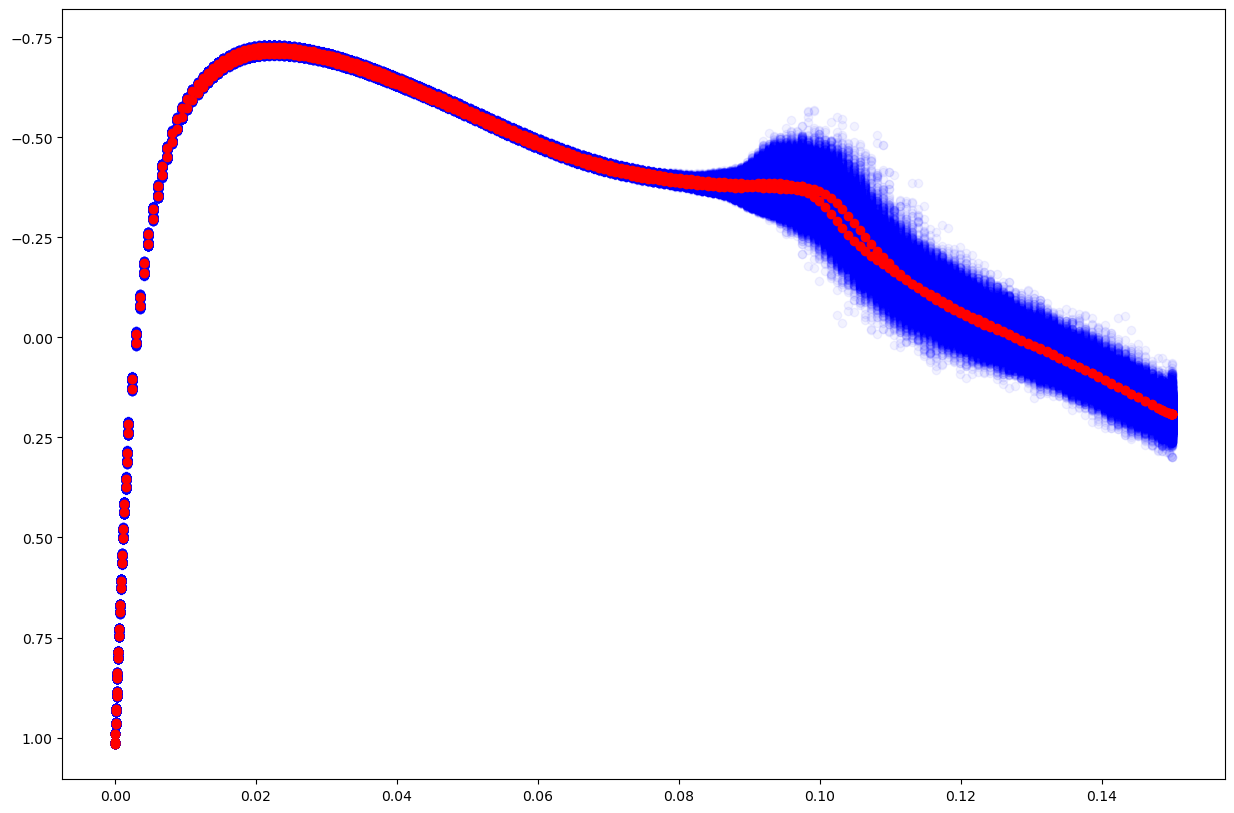

In [14]:
plt.figure(figsize=(15, 10))

AoA = 0
path = "/".join(["Num_data", "AoA" + str(AoA)])
read_param = "cps"

data = trans_file_read(path, read_param)
data_x_suc = data["x_coords_suc"]
data_x_pres = data["x_coords_pres"]
for f, _ in enumerate(data["cs_suc"]):
    data_y = _
    plt.plot(data_x_suc, data_y, linestyle="", marker="o", color="b", alpha=0.05)
for f, _ in enumerate(data["cs_pres"]):
    data_y = _
    plt.plot(data_x_pres, data_y, linestyle="", marker="o", color="b", alpha=0.05)
plt.plot(data_x_suc, data["cs_ave_suc"], linestyle="", marker="o", color="r")
plt.plot(data_x_pres, data["cs_ave_pres"], linestyle="", marker="o", color="r")
if read_param == "cps":
    plt.gca().invert_yaxis()

<a id=cf-x></a>
## $c_{f}-x'$

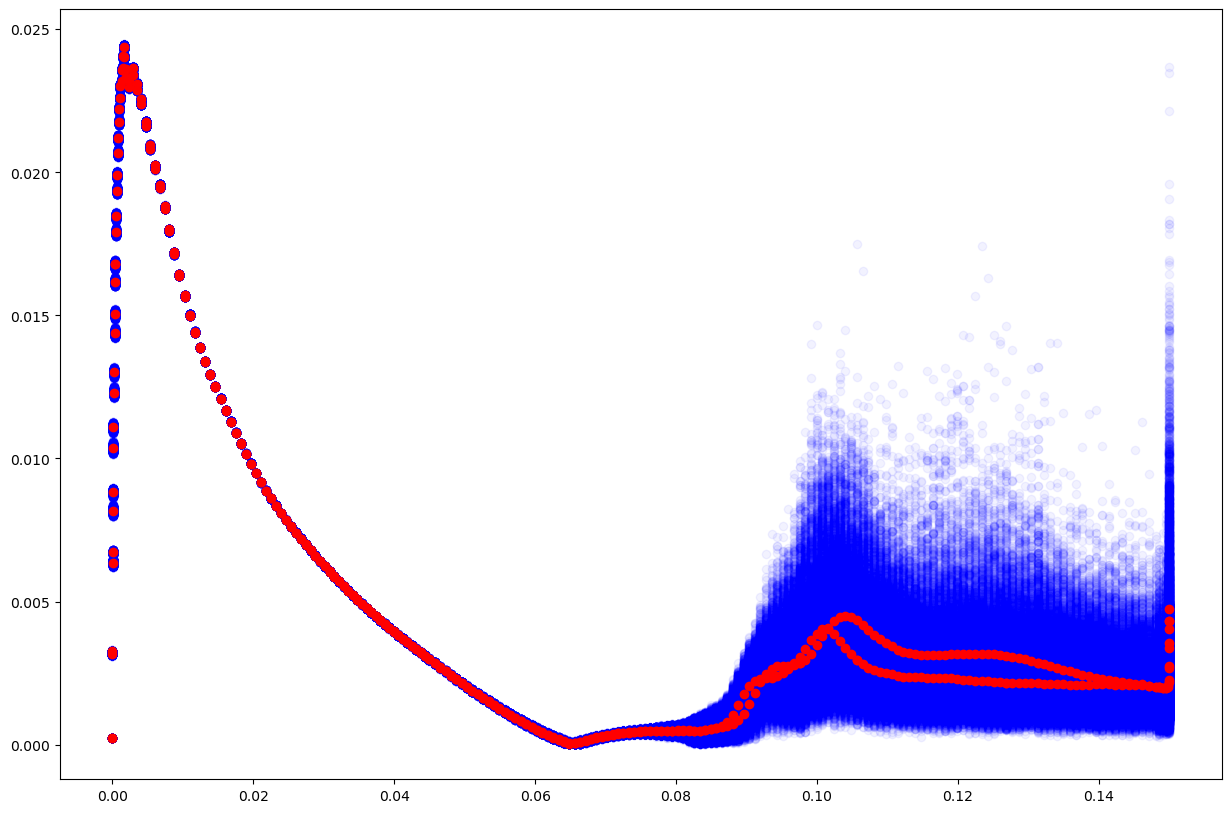

In [15]:
plt.figure(figsize=(15, 10))

AoA = 0
path = "/".join(["Num_data", "AoA" + str(AoA)])
read_param = "cfs"

data = trans_file_read(path, read_param)
data_x_suc = data["x_coords_suc"]
data_x_pres = data["x_coords_pres"]
for f, _ in enumerate(data["cs_suc"]):
    data_y = _
    plt.plot(data_x_suc, data_y, linestyle="", marker="o", color="b", alpha=0.05)
for f, _ in enumerate(data["cs_pres"]):
    data_y = _
    plt.plot(data_x_pres, data_y, linestyle="", marker="o", color="b", alpha=0.05)
plt.plot(data_x_suc, data["cs_ave_suc"], linestyle="", marker="o", color="r")
plt.plot(data_x_pres, data["cs_ave_pres"], linestyle="", marker="o", color="r")
if read_param == "cps":
    plt.gca().invert_yaxis()

<a id=taux-x></a>
## $\tau_{x}-x'$

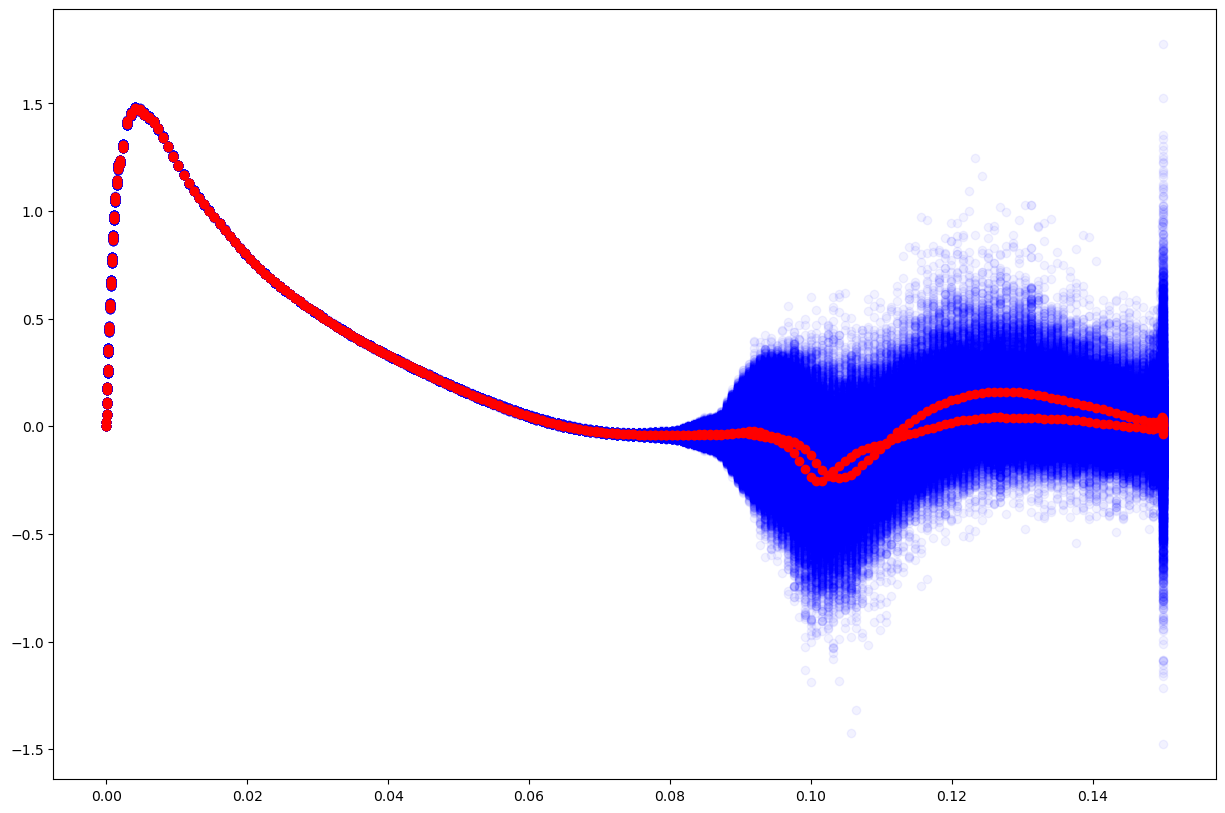

In [16]:
plt.figure(figsize=(15, 10))

AoA = 0
path = "/".join(["Num_data", "AoA" + str(AoA)])
read_param = "tauxs"

data = trans_file_read(path, read_param)
data_x_suc = data["x_coords_suc"]
data_x_pres = data["x_coords_pres"]
for f, _ in enumerate(data["cs_suc"]):
    data_y = _
    plt.plot(data_x_suc, data_y, linestyle="", marker="o", color="b", alpha=0.05)
for f, _ in enumerate(data["cs_pres"]):
    data_y = _
    plt.plot(data_x_pres, data_y, linestyle="", marker="o", color="b", alpha=0.05)
plt.plot(data_x_suc, data["cs_ave_suc"], linestyle="", marker="o", color="r")
plt.plot(data_x_pres, data["cs_ave_pres"], linestyle="", marker="o", color="r")
if read_param == "cps":
    plt.gca().invert_yaxis()